<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/Classifier_to_detect_type_of_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Classifier Model

In [1]:
# Essential Installation for working of notebook
!pip install -U tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.44.1)


### Imports

In [0]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm, trange
from wordcloud import WordCloud
from xgboost import XGBClassifier

### Environment Setup 

In [0]:
SEED=1234
def seed_all(seed=1234):
    """Seed the results for duplication"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [0]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm") 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATASET_LOCATION = '/content/drive/My Drive/Data/GrammarDataset.csv'

## Dataset Overview

In [0]:
original_dataset = pd.read_csv(DATASET_LOCATION, sep="\t")

In [8]:
original_dataset.head()

,Question,key,answer,Type of Question,Sub Section
0,She _________________ some chocolates to the p...,bring,She brought some chocolates to the party.,irregular verb,past simple
1,I _________________ a new song on the radio.,hear,I heard a new song on the radio.,irregular verb,past simple
2,I _________________ three books last week.,read,I read three books last week.,irregular verb,past simple
3,They _________________ French to the waitress.,speak,They spoke French to the waitress.,irregular verb,past simple
4,He _________________ during the class but now ...,understand,He understood during the class but now he doe...,irregular verb,past simple


In [9]:
original_dataset.dtypes

Question            object
key                 object
answer              object
Type of Question    object
Sub Section         object
dtype: object

#### EDA

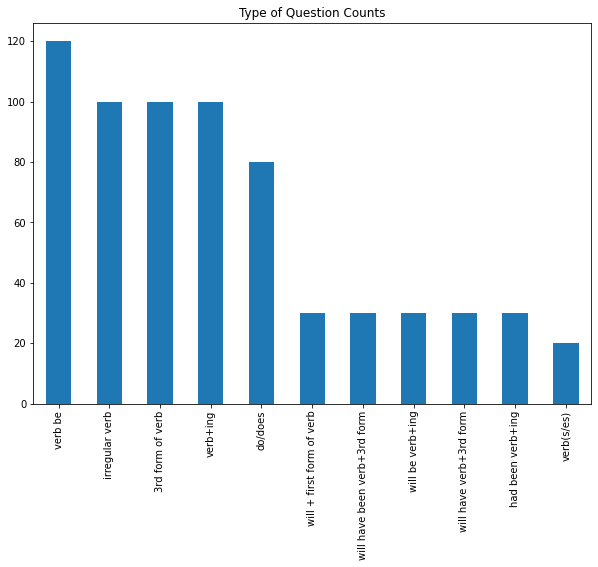

In [10]:
ax, fig = plt.subplots(figsize=(10, 7))
question_class = original_dataset["Type of Question"].value_counts()
question_class.plot(kind='bar')
plt.title('Type of Question Counts')
plt.show()

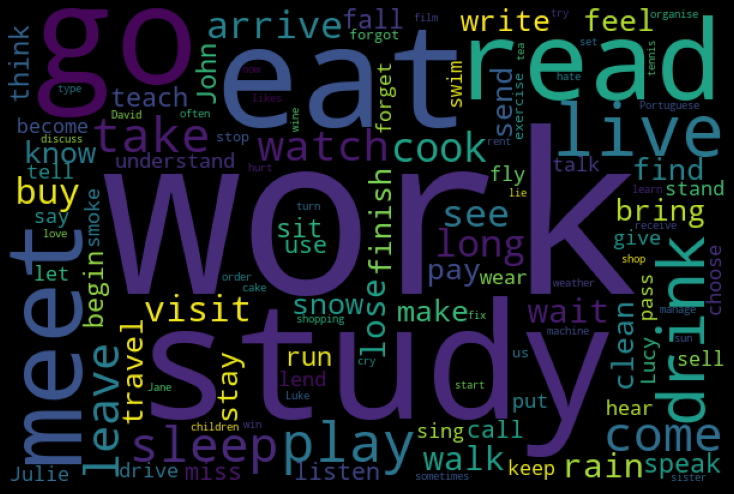

In [11]:
insincere_wordcloud = WordCloud(width=600, height=400).generate(" ".join(original_dataset["key"]))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### PreProcessing

In [0]:
def preprocessor(dataset):
    # Replace continuous underscores with single one
    dataset["Question"] = dataset["Question"].str.replace("[_]{2,}", "_")
    # Remove Brackets
    dataset["Question"] = dataset["Question"].str.replace("[\)\(]", "")
    # Strip whitespaces
    dataset["Question"] = dataset["Question"].apply(lambda x: x.strip())
    # Convert all text to lowercase
    for columns in dataset.columns:
        dataset[columns] = dataset[columns].str.lower() 

    return dataset

In [0]:
original_dataset = preprocessor(original_dataset)

In [14]:
original_dataset.columns

Index(['Question', 'key', 'answer', 'Type of Question', 'Sub Section'], dtype='object')

#### Encoding Labels

In [0]:
label_encoder = LabelEncoder()
original_dataset["Type of Question"] = label_encoder.fit_transform(original_dataset["Type of Question"])

#### Split Training and Testing Data

In [0]:
X_train_orig_dataset, X_test_orig_dataset, y_train_orig_dataset, y_test_orig_dataset = train_test_split(original_dataset[["Question", "key", "answer"]], original_dataset["Type of Question"], random_state=SEED, test_size=0.15)

In [17]:
X_train_orig_dataset.shape, X_test_orig_dataset.shape, y_train_orig_dataset.shape, y_test_orig_dataset.shape

((569, 3), (101, 3), (569,), (101,))

## Experiments:

In [18]:
X_train_orig_dataset.head()

,Question,key,answer
271,how / they / get to work?,they,how do they get to work?
488,we were late for the plane because we _our pas...,forgot,we were late for the plane because we had forg...
131,we _ thirsty.,be,we aren't thirsty.
643,"he_, so the kitchen will be warm.",cook,"he will have been cooking, so the kitchen will..."
155,you / in a cafe?,be,are you in a cafe?


### Experimentation Setup

#### Models

In [0]:
text_vectorizers = [
                    ('CountVectorizer', CountVectorizer(tokenizer=lambda x: x.split())), 
                    ('TfIdFVectorize', TfidfVectorizer(tokenizer=lambda x: x.split()))
                ]
classifiers = [
               ('MultiNomial Naive Bais', MultinomialNB(alpha=0.1)),
               ('LogisticRegression', LogisticRegression(max_iter=5000)), 
               ('SVM', SVC()), ('RandomForest', RandomForestClassifier()), 
               ('XGBClassifier', XGBClassifier(random_state=SEED, learning_rate=0.01))
            ]

In [0]:
def check_classification(X_train, y_train, X_test, y_test):

    # Result DataFrame
    result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
    result_dataframe.set_index('Vectorizer', inplace=True)


    best_score = 0
    best_model = None
    best_pipe = None
    for classifier_name, classifier in classifiers:
        for text_vectorizer_name, text_vectorizer in text_vectorizers:
            pipe = Pipeline(steps=[
                                ('text_vec', text_vectorizer),
                                ('class', classifier)
            ])
            pipe.fit(X_train, y_train)
            f1_measure = f1_score(pipe.predict(X_test), y_test, average='micro')
            # print('Model : {} -> {}:  accuracy: {:.4f}'.format(text_vectorizer_name, classifier_name, acc*100))
            result_dataframe[classifier_name][text_vectorizer_name] = '{:.4f}'.format(f1_measure)

            if f1_measure > best_score:
                best_score = f1_measure
                best_pipe = pipe
                best_model = '{} -> {}'.format(text_vectorizer_name, classifier_name)
    # TODO: Remove while actually writing the code Code for Debugging
    # analyzer = best_pipe['text_vec'].build_analyzer()
    # print(analyzer("i _ the steak for dinner.  choose  i chose the steak for dinner."))
    # print(analyzer("words#i _ words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."))
    # with np.printoptions(threshold=np.inf):
    #     print("First: {}".format(best_pipe['text_vec'].transform(["i _ the steak for dinner.  choose  i chose the steak for dinner."])[0]))
    #     print("Second: {}".format(best_pipe['text_vec'].transform(["words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."])[0]))


    print("\n\nBest F1 Measure was: {:.4f} with the Model: {}".format(best_score, best_model))
    return result_dataframe

#### Result Placeholder

In [0]:
result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
result_dataframe.set_index('Vectorizer', inplace=True)

results = []

#### N-Gram Generator

In [22]:
from itertools import cycle
from collections import deque

def ngrams(sentence, n=2):
    words = [word.text for word in nlp(sentence)]
    d = deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    results = []
    for window, word in zip(cycle((d,)), words):
        results.append([ngram for ngram in window])
        d.append(word)
    results.append([ngram for ngram in d])

    return results

ngrams("this sentence is a test sentence to check ngrams")

[['this', 'sentence'],
 ['sentence', 'is'],
 ['is', 'a'],
 ['a', 'test'],
 ['test', 'sentence'],
 ['sentence', 'to'],
 ['to', 'check'],
 ['check', 'ngrams']]

In [23]:
for n in range(2,5):
    print(" {}-Grams:".format(n), end=" ")
    print(ngrams("Hello World! This is a test example of N-Gram generator", n))

 2-Grams: [['Hello', 'World'], ['World', '!'], ['!', 'This'], ['This', 'is'], ['is', 'a'], ['a', 'test'], ['test', 'example'], ['example', 'of'], ['of', 'N'], ['N', '-'], ['-', 'Gram'], ['Gram', 'generator']]
 3-Grams: [['Hello', 'World', '!'], ['World', '!', 'This'], ['!', 'This', 'is'], ['This', 'is', 'a'], ['is', 'a', 'test'], ['a', 'test', 'example'], ['test', 'example', 'of'], ['example', 'of', 'N'], ['of', 'N', '-'], ['N', '-', 'Gram'], ['-', 'Gram', 'generator']]
 4-Grams: [['Hello', 'World', '!', 'This'], ['World', '!', 'This', 'is'], ['!', 'This', 'is', 'a'], ['This', 'is', 'a', 'test'], ['is', 'a', 'test', 'example'], ['a', 'test', 'example', 'of'], ['test', 'example', 'of', 'N'], ['example', 'of', 'N', '-'], ['of', 'N', '-', 'Gram'], ['N', '-', 'Gram', 'generator']]


#### Sample Generator

In [0]:
def get_input_samples(X, y, n=5):
    results = []
    for i in random.sample(range(len(X) - 1), n):
        results.append("{} --> {} ".format(X.iloc[i], label_encoder.inverse_transform([y.iloc[i]])))

    return results

### Experiment 1:  Word#\$\{$words_i$\}
Concatenating Question + key + answer in a Bag Of Words Approach \\
No Feature Engineering

In [0]:
experiment_text = "Concatenating question + key + answer. like word#word_i"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [27]:
def add_word_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("words#{}".format(token.text))

    return " ".join(text)

add_word_template("i _ the steak for dinner.  choose  i chose the steak for dinner.")

'words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#.'

In [28]:
X_train = X_train.progress_apply(add_word_template)
X_test = X_test.progress_apply(add_word_template)

#### Input Samples

In [29]:
get_input_samples(X_train, y_train)

["words#they words#_ words#so words#we words#went words#to words#a words#restaurant words#. words#not words#eat words#they words#had words#n't words#eaten words#so words#we words#went words#to words#a words#restaurant words#. --> ['3rd form of verb'] ",
 "words#when words#/ words#you words#/ words#leave words#? words#you words#leave words#when words#are words#you words#leaving words#? --> ['verb+ing'] ",
 "words#they words#/ words#live words#in words#london words#live words#they words#live words#in words#london words#. --> ['verb(s/es)'] ",
 "words#_ words#football words#when words#he words#was words#injured words#? words#how words#long words#he words#play words#how words#long words#had words#he words#been words#playing words#football words#when words#he words#was words#injured words#? --> ['had been verb+ing'] ",
 "words#_ words#the words#film words#already words#? words#she words#see words#had words#she words#seen words#the words#film words#already words#? --> ['3rd form of verb'] "]

#### Experimentation Results

In [30]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result

# First:   (0, 24)	1
#   (0, 193)	1
#   (0, 194)	1
#   (0, 257)	2
#   (0, 356)	2
#   (0, 447)	2
#   (0, 851)	2
#   (0, 912)	2
# Second:   (0, 24)



Best F1 Measure was: 0.9703 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406


### Experiment 2: word_pos#\$\{$word_i$\}_\$\{$pos_i$\}
With Word and POS tags, token.tag_ gives a detailed POS tag where we can distinguish between forms of verb. \\
More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [33]:
def add_word_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos#{}_{}".format(token.text, token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_word_pos_template(test_sentence)

"word_pos#testing_VBG word_pos#the_DT word_pos#pos_NN word_pos#tagger_NN word_pos#in_IN word_pos#this_DT word_pos#sentence_NN word_pos#let_VB word_pos#'s_PRP word_pos#see_VB word_pos#how_WRB word_pos#it_PRP word_pos#works_VBZ word_pos#!_."

In [34]:
X_train = X_train.progress_apply(add_word_pos_template)
X_test = X_test.progress_apply(add_word_pos_template)

#### Input Samples

In [35]:
get_input_samples(X_train, y_train)

["word_pos#she_PRP word_pos#/_SYM word_pos#love_NN word_pos#chocolate_NN word_pos#love_NN word_pos#she_PRP word_pos#loves_VBZ word_pos#chocolate_NN word_pos#._. --> ['verb(s/es)'] ",
 "word_pos#what_WP word_pos#/_NFP word_pos#that_DT word_pos#noise_NN word_pos#/_, word_pos#be_VB word_pos#?_. word_pos#be_VB word_pos#what_WP word_pos#was_VBD word_pos#that_DT word_pos#noise_NN word_pos#?_. --> ['verb be'] ",
 "word_pos#__NNP word_pos#tomorrow_NN word_pos#?_. word_pos#they_PRP word_pos#come_VBP word_pos#will_MD word_pos#they_PRP word_pos#come_VB word_pos#tomorrow_NN word_pos#?_. --> ['will + first form of verb'] ",
 "word_pos#where_WRB word_pos#/_NFP word_pos#we_PRP word_pos#?_. word_pos#be_VB word_pos# __SP word_pos#where_WRB word_pos#are_VBP word_pos#we_PRP word_pos#?_. --> ['verb be'] ",
 "word_pos#she_PRP word_pos#/_SYM word_pos#eat_VB word_pos#chocolate_NN word_pos#eat_VB word_pos#she_PRP word_pos#'s_VBZ word_pos#eating_VBG word_pos#chocolate_NN word_pos#._. --> ['verb+ing'] "]

#### Experimentation Results

In [36]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9604 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7525,0.9604,0.9406
TfIdFVectorize,0.6733,0.7327,0.7129,0.9208,0.8812


### Experiment 3: pos#\$\{$pos_i$\} 
With just POS

In [0]:
experiment_text = "Classifying based on POS tags pos#{pos_i}"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [39]:
def add_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("pos#{}".format(token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_template(test_sentence)

'pos#VBG pos#DT pos#NN pos#NN pos#IN pos#DT pos#NN pos#VB pos#PRP pos#VB pos#WRB pos#PRP pos#VBZ pos#.'

In [40]:
X_train = X_train.progress_apply(add_pos_template)
X_test = X_test.progress_apply(add_pos_template)

#### Input Samples

In [41]:
get_input_samples(X_train, y_train)

["pos#WP pos#NNP pos#IN pos#DT pos#NN pos#IN pos#DT pos#NN pos#. pos#PRP pos#VBP pos#WP pos#MD pos#PRP pos#VB pos#VBN pos#IN pos#DT pos#NN pos#IN pos#DT pos#NN pos#. --> ['will have verb+3rd form'] ",
 "pos#PRP pos#: pos#RB pos#SYM pos#UH pos#NN pos#RB pos#PRP pos#VBP pos#RB pos#VB pos#NN pos#. --> ['do/does'] ",
 "pos#WP pos#NFP pos#DT pos#NN pos#, pos#VB pos#. pos#VB pos#WP pos#VBD pos#DT pos#NN pos#. --> ['verb be'] ",
 "pos#WDT pos#NN pos#NNP pos#NN pos#. pos#DT pos#NN pos#VBD pos#WP pos#NN pos#MD pos#DT pos#NN pos#VB pos#NN pos#. --> ['will + first form of verb'] ",
 "pos#PRP pos#NNP pos#IN pos#DT pos#NN pos#TO pos#VB pos#IN pos#DT pos#NN pos#. pos#VB pos#PRP pos#VBD pos#IN pos#DT pos#NN pos#TO pos#VB pos#IN pos#DT pos#NN pos#. --> ['irregular verb'] "]

#### Experimentation Results

In [42]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6238,0.8218,0.7624,0.9307,0.8713
TfIdFVectorize,0.6634,0.6832,0.7129,0.8713,0.7822


### Experiment 4: word\_tag#\${$word_i$}_\${$( q, k, a )$}
With Question, Key, Answer Tagging

In [0]:
experiment_text = "Tagging word with q, k, a example: word_tag#{word_i}_{q/k/a}"

#### Preprocessing

In [44]:
def add_word_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_tag#{}_{}".format(token.text, tag))
    
    return " ".join(text)

add_word_tag_template("test sentence", "q")

'word_tag#test_q word_tag#sentence_q'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [46]:
get_input_samples(X_train, y_train)

["word_tag#mrs_q word_tag#._q word_tag#brown_q word_tag#/_q word_tag#not_q word_tag#/_q word_tag#walk_q word_tag#in_q word_tag#the_q word_tag#garden_q word_tag#when_q word_tag#the_q word_tag#murder_q word_tag#happened_q word_tag#not_k word_tag#walk_k word_tag#mrs_a word_tag#._a word_tag#brown_a word_tag#was_a word_tag#n't_a word_tag#walking_a word_tag#in_a word_tag#the_a word_tag#garden_a word_tag#._a --> ['verb+ing'] ",
 "word_tag#she_q word_tag#told_q word_tag#me_q word_tag#that_q word_tag#she_q word_tag#__q word_tag#a_q word_tag#lot_q word_tag#before_q word_tag#the_q word_tag#exam_q word_tag#._q word_tag#study_k word_tag#she_a word_tag#told_a word_tag#me_a word_tag#that_a word_tag#she_a word_tag#had_a word_tag#studied_a word_tag#a_a word_tag#lot_a word_tag#before_a word_tag#the_a word_tag#exam_a word_tag#._a --> ['3rd form of verb'] ",
 "word_tag#lucy_q word_tag#/_q word_tag#not_q word_tag#/_q word_tag#do_q word_tag#/_q word_tag#her_q word_tag#homework_q word_tag#not_k word_tag#do_k

#### Experimentation Results

In [47]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9802 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9505,0.8812,0.9604,0.9802
TfIdFVectorize,0.7525,0.8713,0.8317,0.9010,0.9505


### Experiment 5: word_pos_tag#\${$word_i$}_\${$pos_i$}_{(q, k, a)}
POS Tagger with q,k,a tagging

In [0]:
experiment_text = "Adding POS Tagging and qka tagging example: word_pos_tag#{word_i}_{pos_i}_{(q, k, a)}"

#### Preprocessing

In [49]:
def add_word_pos_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos_tag#{}_{}_{}".format(token.text, token.tag_, tag))

    return " ".join(text)

add_word_pos_tag_template("this is test example", "a")

'word_pos_tag#this_DT_a word_pos_tag#is_VBZ_a word_pos_tag#test_NN_a word_pos_tag#example_NN_a'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [51]:
get_input_samples(X_train, y_train)

["word_pos_tag#we_PRP_q word_pos_tag#/_:_q word_pos_tag#not_RB_q word_pos_tag#/_SYM_q word_pos_tag#watch_VB_q word_pos_tag#tv_NN_q word_pos_tag#at_IN_q word_pos_tag#the_DT_q word_pos_tag#moment_NN_q word_pos_tag#not_RB_k word_pos_tag#watch_VB_k word_pos_tag#we_PRP_a word_pos_tag#are_VBP_a word_pos_tag#n't_RB_a word_pos_tag#watching_VBG_a word_pos_tag#tv_NN_a word_pos_tag#at_IN_a word_pos_tag#the_DT_a word_pos_tag#moment_NN_a word_pos_tag#._._a --> ['verb+ing'] ",
 "word_pos_tag#they_PRP_q word_pos_tag#/_:_q word_pos_tag#not_RB_q word_pos_tag#/_SYM_q word_pos_tag#have_VB_q word_pos_tag#a_DT_q word_pos_tag#car_NN_q word_pos_tag#not_RB_k word_pos_tag#they_PRP_a word_pos_tag#do_VBP_a word_pos_tag#n't_RB_a word_pos_tag#have_VB_a word_pos_tag#a_DT_a word_pos_tag#car_NN_a word_pos_tag#._._a --> ['do/does'] ",
 "word_pos_tag#john_NNP_q word_pos_tag#/_SYM_q word_pos_tag#come_VBN_q word_pos_tag#from_IN_q word_pos_tag#new_NNP_q word_pos_tag#zealand_NNP_q word_pos_tag#?_._q word_pos_tag#come_VB_k 

#### Experimentation Results

In [52]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> LogisticRegression


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9307,0.8614,0.9109,0.9307
TfIdFVectorize,0.7822,0.8416,0.8218,0.8416,0.9307


### Experiment 6: word#{$word_i$} word_pos_tag#\${$word_i$}_\${$pos_i$}_{(q, k, a)}

In [0]:
experiment_text = "Combining word and word_pos_tags"

#### Preprocessing

In [54]:
def add_word_and_word_pos_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word#{} word_pos_tag##{}_{}_{}".format(token.text, token.text, token.tag_, tag))

    return " ".join(text)

add_word_and_word_pos_tag_template("This is a test sentence! We will see the difference between playing and played", "q")

'word#This word_pos_tag##This_DT_q word#is word_pos_tag##is_VBZ_q word#a word_pos_tag##a_DT_q word#test word_pos_tag##test_NN_q word#sentence word_pos_tag##sentence_NN_q word#! word_pos_tag##!_._q word#We word_pos_tag##We_PRP_q word#will word_pos_tag##will_MD_q word#see word_pos_tag##see_VB_q word#the word_pos_tag##the_DT_q word#difference word_pos_tag##difference_NN_q word#between word_pos_tag##between_IN_q word#playing word_pos_tag##playing_VBG_q word#and word_pos_tag##and_CC_q word#played word_pos_tag##played_VBD_q'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_and_word_pos_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_and_word_pos_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_and_word_pos_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_and_word_pos_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_and_word_pos_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_and_word_pos_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [56]:
get_input_samples(X_train, y_train)

["word#i word_pos_tag##i_PRP_q word#_ word_pos_tag##__NNP_q word#a word_pos_tag##a_DT_q word#new word_pos_tag##new_JJ_q word#song word_pos_tag##song_NN_q word#on word_pos_tag##on_IN_q word#the word_pos_tag##the_DT_q word#radio word_pos_tag##radio_NN_q word#. word_pos_tag##._._q word#  word_pos_tag## __SP_k word#hear word_pos_tag##hear_NNP_k word#  word_pos_tag## __SP_a word#i word_pos_tag##i_PRP_a word#heard word_pos_tag##heard_VBD_a word#a word_pos_tag##a_DT_a word#new word_pos_tag##new_JJ_a word#song word_pos_tag##song_NN_a word#on word_pos_tag##on_IN_a word#the word_pos_tag##the_DT_a word#radio word_pos_tag##radio_NN_a word#. word_pos_tag##._._a --> ['irregular verb'] ",
 "word#i word_pos_tag##i_PRP_q word#'d word_pos_tag##'d_MD_q word#_ word_pos_tag##__NNP_q word#a word_pos_tag##a_DT_q word#lovely word_pos_tag##lovely_JJ_q word#new word_pos_tag##new_JJ_q word#bike word_pos_tag##bike_NN_q word#for word_pos_tag##for_IN_q word#my word_pos_tag##my_PRP$_q word#birthday word_pos_tag##bir

#### Experimentation Results

In [57]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9901 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7525,0.9307,0.8416,0.9901,0.9703
TfIdFVectorize,0.7129,0.8020,0.7723,0.9307,0.9208


### Experiment 7: ngram#{$word_i$}_{$word_{i+1}$}

In [0]:
experiment_text = "Adding bigrams of words bigram#{word_i}_{word_i+1}"

#### Preprocessing

In [59]:
def add_ngram_template(text, n=2):
    tokens = ngrams(text, n)
    text = []
    for token in tokens:
        text.append("ngram#{}".format("_".join(token)))

    return " ".join(text)

add_ngram_template("This is a test sentence! We will see the difference between playing and played")

'ngram#This_is ngram#is_a ngram#a_test ngram#test_sentence ngram#sentence_! ngram#!_We ngram#We_will ngram#will_see ngram#see_the ngram#the_difference ngram#difference_between ngram#between_playing ngram#playing_and ngram#and_played'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_ngram_template(x)) + " " + X_train_orig_dataset["key"].apply(lambda x: add_ngram_template(x)) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_ngram_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_ngram_template(x)) + " " + X_test_orig_dataset["key"].apply(lambda x: add_ngram_template(x)) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_ngram_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [61]:
get_input_samples(X_train, y_train)

["ngram#it__ ngram#__cold ngram#cold_last ngram#last_night ngram#night_. ngram#be ngram#it_was ngram#was_cold ngram#cold_last ngram#last_night ngram#night_. --> ['irregular verb'] ",
 "ngram#he__ ngram#__in ngram#in_the ngram#the_library ngram#library_. ngram#study ngram#he_will ngram#will_be ngram#be_studying ngram#studying_in ngram#in_the ngram#the_library ngram#library_. --> ['will be verb+ing'] ",
 "ngram#he_/ ngram#/_work ngram#work_in ngram#in_a ngram#a_restaurant ngram#work ngram#he_works ngram#works_in ngram#in_a ngram#a_restaurant ngram#restaurant_. --> ['verb(s/es)'] ",
 "ngram#lucy_/ ngram#/_study ngram#study_history ngram#history_? ngram#study ngram#does_lucy ngram#lucy_study ngram#study_history ngram#history_? --> ['do/does'] ",
 "ngram#__tomorrow ngram#tomorrow_? ngram#they_come ngram#will_they ngram#they_come ngram#come_tomorrow ngram#tomorrow_? --> ['will + first form of verb'] "]

#### Experimentation Results

In [62]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8020 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6931,0.7723,0.6040,0.8020,0.6535
TfIdFVectorize,0.6634,0.6139,0.5743,0.7822,0.7129


### Experiment 8: ngrampos#{$pos_i$}_{$pos_{i+1}$}

In [0]:
experiment_text = "Adding bigrams of pos tags ngrampos#{pos_i}_{pos_i+1}"

#### Preprocessing

In [64]:
def add_ngram_pos_template(text, n=2):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}".format(token.tag_))

    text = " ".join(text)

    tokens = ngrams(text, n)
    text = []
    for token in tokens:
        text.append("ngrampos#{}".format("_".join(token)))

    return " ".join(text)

add_ngram_pos_template("This is a test sentence! We will see the difference between playing and played")

'ngrampos#DT_VBZ ngrampos#VBZ_DT ngrampos#DT_NN ngrampos#NN_NN ngrampos#NN_. ngrampos#._PRP ngrampos#PRP_MD ngrampos#MD_VB ngrampos#VB_DT ngrampos#DT_NN ngrampos#NN_IN ngrampos#IN_VBG ngrampos#VBG_CC ngrampos#CC_VBD'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_ngram_pos_template(x)) + " " + X_train_orig_dataset["key"].apply(lambda x: add_ngram_pos_template(x)) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_ngram_pos_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_ngram_pos_template(x)) + " " + X_test_orig_dataset["key"].apply(lambda x: add_ngram_pos_template(x)) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_ngram_pos_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [66]:
get_input_samples(X_train, y_train)

["ngrampos#DT_NNP ngrampos#NNP_, ngrampos#,_RB ngrampos#RB_SYM ngrampos#SYM_VB ngrampos#VB_DT ngrampos#DT_NNS ngrampos#NNS_WRB ngrampos#WRB_DT ngrampos#DT_NN ngrampos#NN_VBD ngrampos#RB_JJ ngrampos#DT_NNP ngrampos#NNP_VBD ngrampos#VBD_RB ngrampos#RB_VBG ngrampos#VBG_DT ngrampos#DT_NNS ngrampos#NNS_. --> ['verb+ing'] ",
 "ngrampos#NNP_SYM ngrampos#SYM_VBN ngrampos#VBN_IN ngrampos#IN_NNP ngrampos#NNP_NNP ngrampos#NNP_. ngrampos#VB ngrampos#VBZ_NNP ngrampos#NNP_VB ngrampos#VB_IN ngrampos#IN_NNP ngrampos#NNP_NNP ngrampos#NNP_. --> ['do/does'] ",
 "ngrampos#PRP_: ngrampos#:_VB ngrampos#VB_. ngrampos#VB ngrampos#VBP_PRP ngrampos#PRP_VBG ngrampos#VBG_. --> ['verb+ing'] ",
 "ngrampos#NNP_NNP ngrampos#NNP_NNP ngrampos#NNP_. ngrampos#NNP ngrampos#NNP_MD ngrampos#MD_VB ngrampos#VB_VBN ngrampos#VBN_NNP ngrampos#NNP_. --> ['will have verb+3rd form'] ",
 "ngrampos#PRP_NNP ngrampos#NNP_IN ngrampos#IN_NNP ngrampos#NNP_. ngrampos#VB ngrampos#PRP_VBP ngrampos#VBP_RB ngrampos#RB_IN ngrampos#IN_NNP ngramp

#### Experimentation Results

In [67]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9010 with the Model: CountVectorizer -> LogisticRegression


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8218,0.9010,0.8119,0.8911,0.8614
TfIdFVectorize,0.7921,0.8317,0.8020,0.9010,0.8218


# Results

In [68]:
from IPython.display import display, HTML

for i, (description, result) in enumerate(results):
    print("Experiment {}:".format(i+1))
    print(description)
    display(HTML(result.to_html()))
    print("\n\n")

Experiment 1:
Concatenating question + key + answer. like word#word_i


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406





Experiment 2:
Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7525,0.9604,0.9406
TfIdFVectorize,0.6733,0.7327,0.7129,0.9208,0.8812





Experiment 3:
Classifying based on POS tags pos#{pos_i}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6238,0.8218,0.7624,0.9307,0.8713
TfIdFVectorize,0.6634,0.6832,0.7129,0.8713,0.7822





Experiment 4:
Tagging word with q, k, a example: word_tag#{word_i}_{q/k/a}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9505,0.8812,0.9604,0.9802
TfIdFVectorize,0.7525,0.8713,0.8317,0.9010,0.9505





Experiment 5:
Adding POS Tagging and qka tagging example: word_pos_tag#{word_i}_{pos_i}_{(q, k, a)}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9307,0.8614,0.9109,0.9307
TfIdFVectorize,0.7822,0.8416,0.8218,0.8416,0.9307





Experiment 6:
Combining word and word_pos_tags


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7525,0.9307,0.8416,0.9901,0.9703
TfIdFVectorize,0.7129,0.8020,0.7723,0.9307,0.9208





Experiment 7:
Adding bigrams of words bigram#{word_i}_{word_i+1}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6931,0.7723,0.6040,0.8020,0.6535
TfIdFVectorize,0.6634,0.6139,0.5743,0.7822,0.7129





Experiment 8:
Adding bigrams of pos tags ngrampos#{pos_i}_{pos_i+1}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8218,0.9010,0.8119,0.8911,0.8614
TfIdFVectorize,0.7921,0.8317,0.8020,0.9010,0.8218


# Summary

After these series of experiments, we could distinguish the important featues



1.   Q/K/A Tagging was one of the most important feature
2.   POS tagging with different form of verbs improved the performance over
3.   Combination of QKA and POS tag was is an important feature too
4.   N-Grams (bi) were not that effective while classifying with this data
5.   Random Forest, Logistic Regression and XGBClassifier all these three can be a valid choice while selecting classifier for this classification

